In [ ]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # link to the datasets
BLUR = "/content/drive/MyDrive/CloudSalesDataSet/gopro/train/blur"
SHARP = "/content/drive/MyDrive/CloudSalesDataSet/gopro/train/sharp"
TEST_BLUR = "/content/drive/MyDrive/CloudSalesDataSet/gopro/test/blur"
TEST_SHARP = "/content/drive/MyDrive/CloudSalesDataSet/gopro/test/sharp"

In [ ]:
# Initializing the parameters
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

In [ ]:
LAMBDA = 100

In [ ]:
# converting the images to tensors for train data
def load(file_path):
  image_file = tf.strings.split(file_path, os.sep)[-1]
  image_b = tf.io.read_file(BLUR + '/' + image_file)
  image_b = tf.io.decode_png(image_b)
  image_s = tf.io.read_file(SHARP + '/' + image_file)
  image_s = tf.io.decode_png(image_s)

  input_image = tf.cast(image_b, tf.float32)
  sharp_image = tf.cast(image_s, tf.float32)

  return input_image, sharp_image

In [ ]:
# converting the images to tensors for test data
def load_test(file_path):
  image_file = tf.strings.split(file_path, os.sep)[-1]
  image_b = tf.io.read_file(TEST_BLUR + '/' + image_file)
  image_b = tf.io.decode_png(image_b)
  image_s = tf.io.read_file(TEST_SHARP + '/' + image_file)
  image_s = tf.io.decode_png(image_s)

  input_image = tf.cast(image_b, tf.float32)
  sharp_image = tf.cast(image_s, tf.float32)

  return input_image, sharp_image

In [ ]:
# resizing the tensors
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
 # stacking the images together then cropping them
def random_crop(input_image, real_image):
	stacked_image = tf.stack([input_image, real_image], axis=0)
	cropped_image = tf.image.random_crop(
	stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

	return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing so the value is between 0 and 1
def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image

In [ ]:
# data augmnetation function to ensure generalization
@tf.function()
def random_jitter(input_image, real_image):
	input_image, real_image = resize(input_image, real_image, 286, 286)
	input_image, real_image = random_crop(input_image, real_image)

	if tf.random.uniform(()) > 0.5:
		input_image = tf.image.flip_left_right(input_image)
		real_image = tf.image.flip_left_right(real_image)

	return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load_test(image_file)
  input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
	input_image, real_image = load(image_file)
	input_image, real_image = random_jitter(input_image, real_image)
	input_image, real_image = normalize(input_image, real_image)
	return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(SHARP + '/*.png'))
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
# reflection padding to minimize the boundary artifacts
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [ ]:
def res_net(input, filters, kernel_size, strides=(1, 1), apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  x = ReflectionPadding2D(padding=(1,1))(input)
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                kernel_initializer=initializer, strides=strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.nn.relu(x)

  if apply_dropout:
    x = tf.keras.layers.Dropout(0.5)(x)

  x = ReflectionPadding2D(padding=(1,1))(x)
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                kernel_initializer=initializer, strides=strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  merged = tf.keras.layers.Add()([input, x])
  return merged

In [ ]:
def Generator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # 7x7 Conv n64
  x = ReflectionPadding2D(padding=(3,3))(inputs)
  x = tf.keras.layers.Conv2D(64, kernel_size=(7,7), padding='valid',kernel_initializer=initializer)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.nn.relu(x)

  # 3x3 Conv n128s2
  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=2,
               kernel_initializer=initializer)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.nn.relu(x)

  # 3x3 Conv n256s2
  x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=2,
               kernel_initializer=initializer)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.nn.relu(x)

  # 9 resnet blocks n256
  for _ in range(9):
    x = res_net(x, 256, kernel_size=(3,3), apply_dropout=True)

  # upsampling n128
  x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(x)
  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same',
               kernel_initializer=initializer)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.nn.relu(x)

  # upsampling n64
  x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(x)
  x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same',
               kernel_initializer=initializer)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.nn.relu(x)

  # 7x7 Conv n64
  x = ReflectionPadding2D(padding=(3,3))(x)
  x = tf.keras.layers.Conv2D(filters=OUTPUT_CHANNELS, kernel_size=(7,7), padding='valid',
               kernel_initializer=initializer)(x)
  x = tf.nn.tanh(x)

  outputs = tf.keras.layers.Add()([x, inputs])
  outputs = tf.keras.layers.Lambda(lambda z: z/2)(outputs)

  model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='Generator')
  return model

In [ ]:
generator = Generator()

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
loss_model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
def perceptual_loss(y_true, y_pred):
  return tf.reduce_mean(tf.square(loss_model(y_true) - loss_model(y_pred)))

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = -tf.reduce_mean(disc_generated_output)

  l2_loss = perceptual_loss(target, gen_output)

  total_gen_loss = gan_loss + LAMBDA*l2_loss

  return total_gen_loss, gan_loss, l2_loss

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()

In [ ]:
def wasserstein_loss(y_true, y_pred):
  return tf.reduce_mean(y_true * y_pred)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = wasserstein_loss(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = wasserstein_loss(tf.zeros_like(disc_real_output), disc_generated_output)

  total_disc_loss = tf.reduce_mean(real_loss + generated_loss)

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
checkpoint_prefix = '/content/drive/MyDrive/checkpoints/ckpt'
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
log_dir="/content/drive/MyDrive/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function()
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l2_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, steps):
  example_input, example_target = next(iter(train_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 1000 steps: 47.27 sec



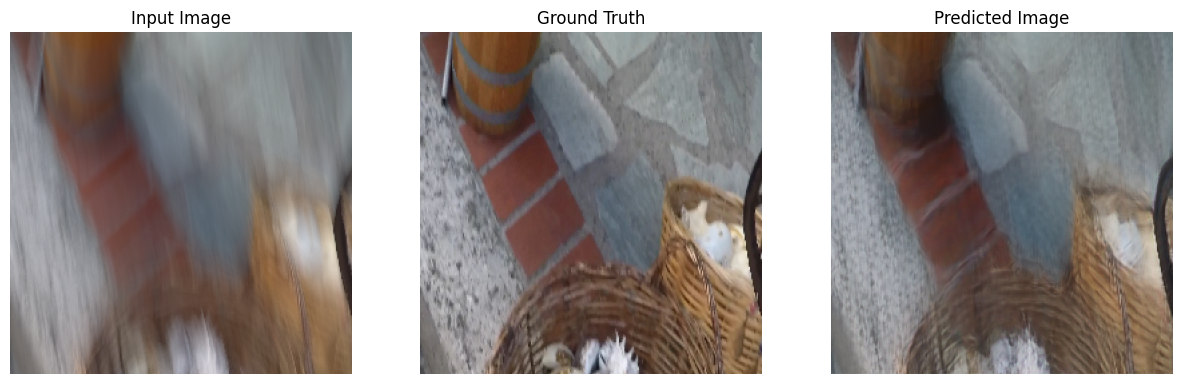

Step: 299k
....................................................................................................

In [ ]:
fit(train_dataset, steps=400000)

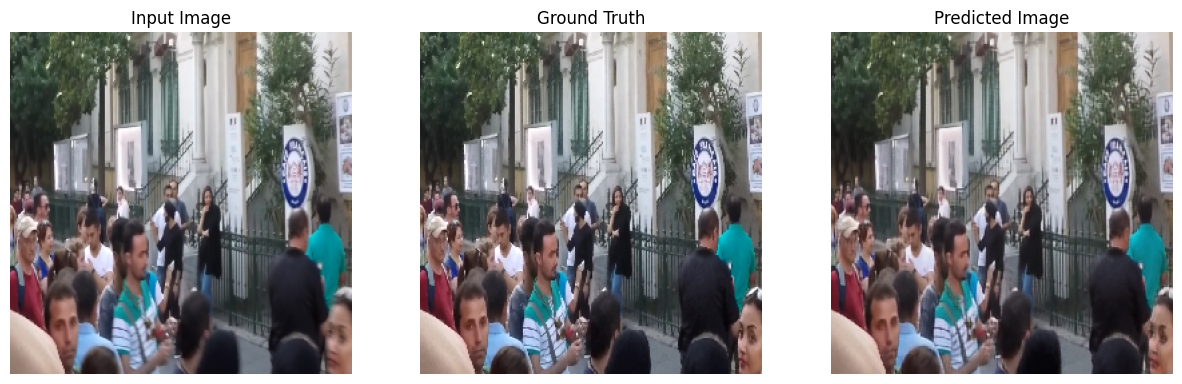

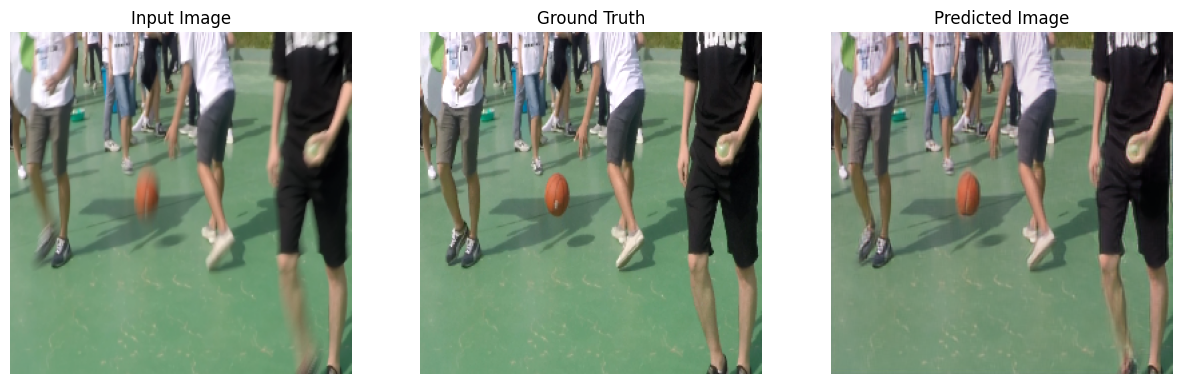

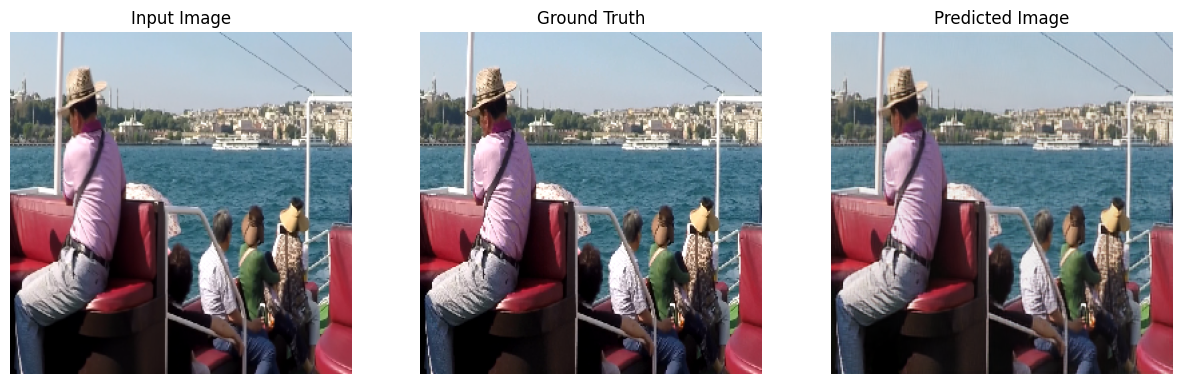

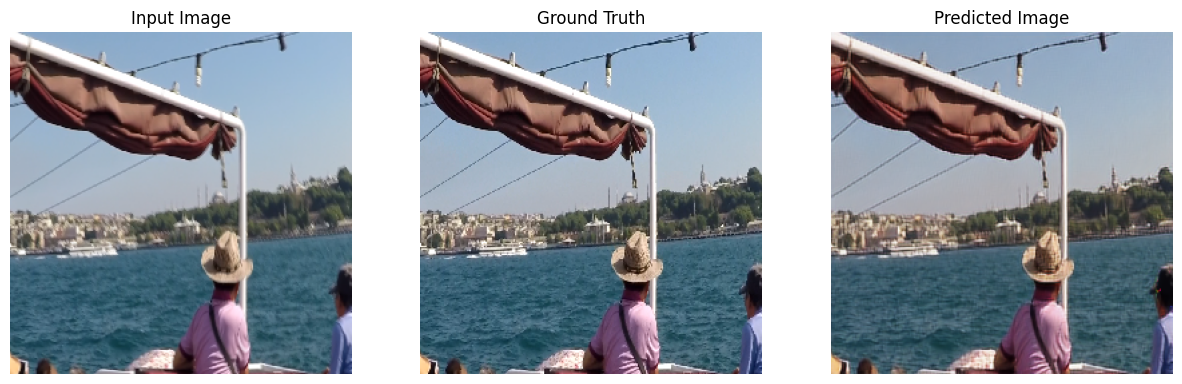

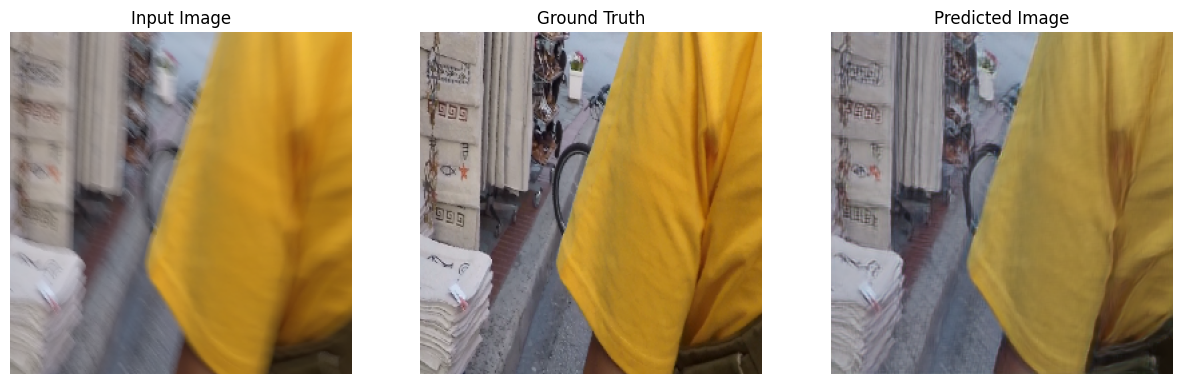

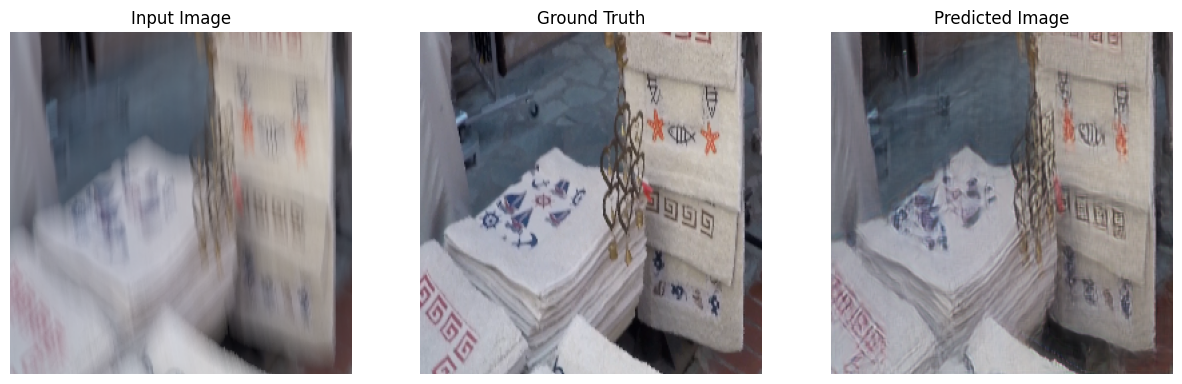

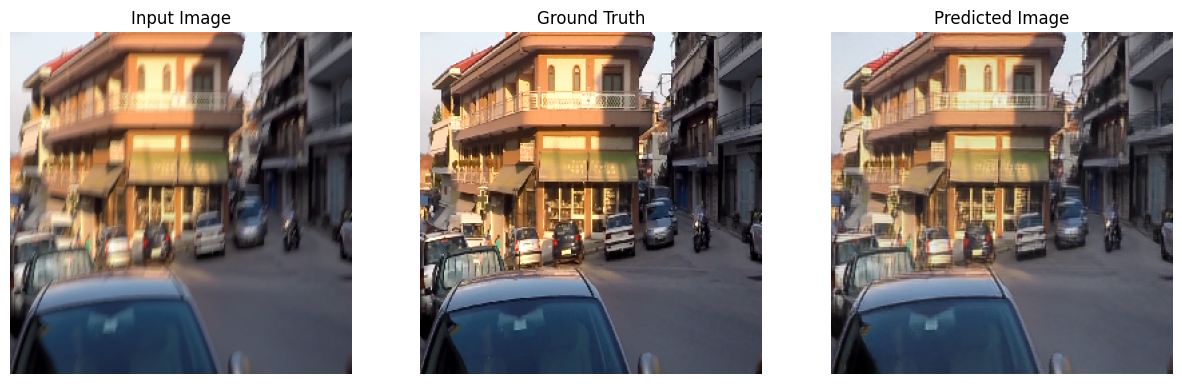

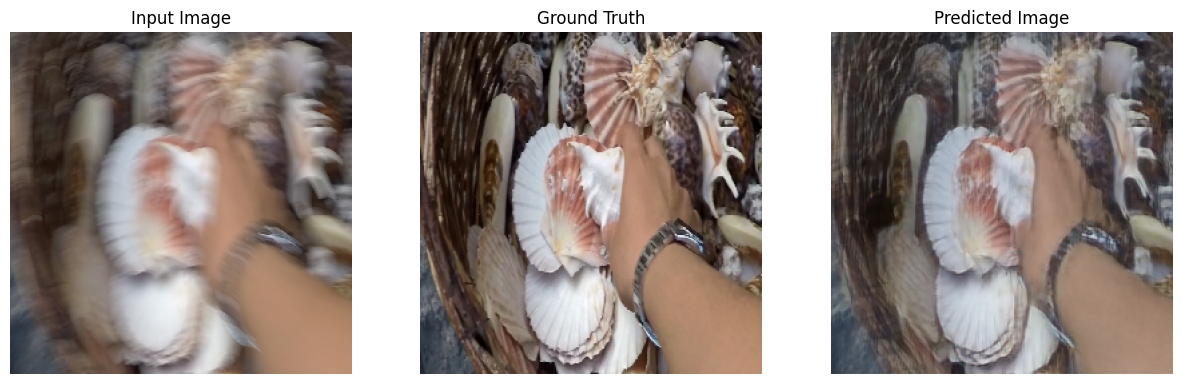

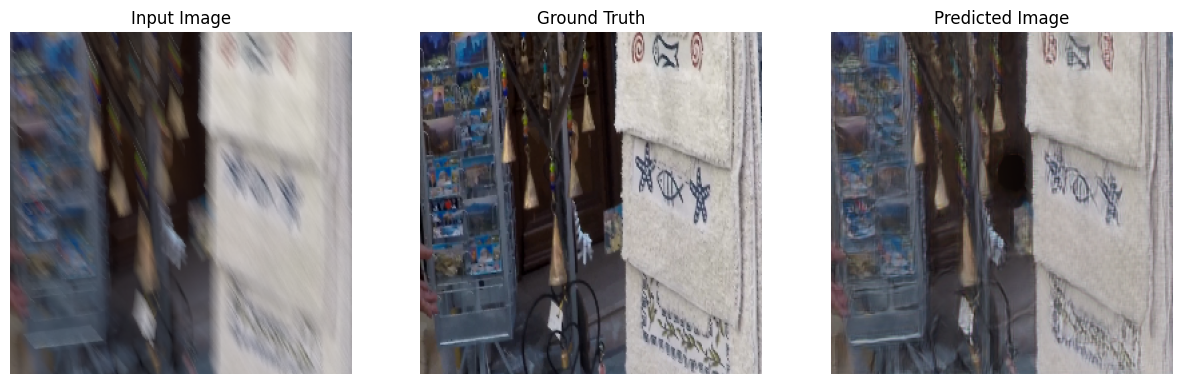

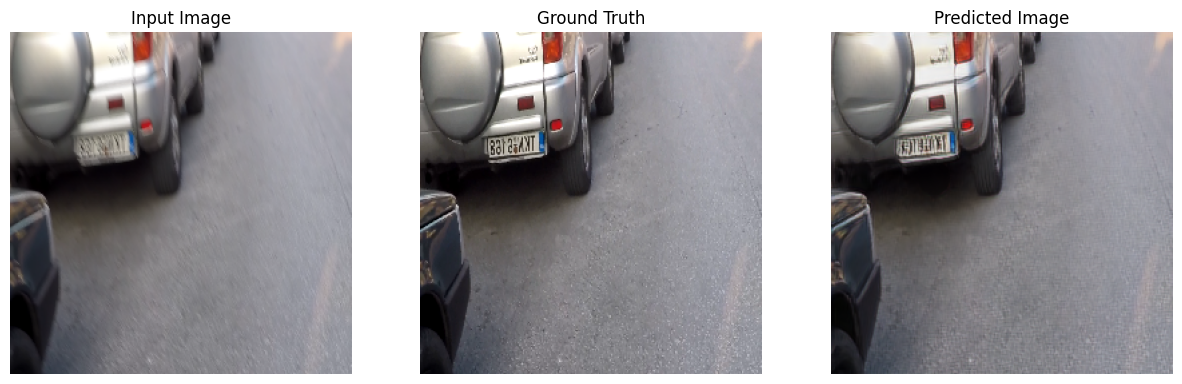

In [ ]:
for inp, tar in train_dataset.take(10):
  generate_images(generator, inp, tar)

In [ ]:
ssims = []
for inp, tar in train_dataset.take(30):
    ssim = tf.image.ssim(tar, generator(inp), max_val=1, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    ssims.append(ssim)
tf.reduce_mean(ssims)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6898083>

In [ ]:
psnrs = []
for inp, tar in train_dataset.take(30):
    psnr = tf.image.psnr(tar, generator(inp), max_val=1)
    psnrs.append(psnr)
tf.reduce_mean(psnrs)

<tf.Tensor: shape=(), dtype=float32, numpy=17.750492>

In [ ]:
custom_objects = {'ReflectionPadding2D': ReflectionPadding2D}

In [ ]:
# Save the generator model
generator.save('/content/drive/MyDrive/goproModelGAN/generator_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
discriminator.save('/content/drive/MyDrive/goproModelGAN/discriminator_model.h5')